# tRNA-Seq simulator

tRNA-Seq generates reads which are annotated through alignment to a pre-defined set of reference sequences.
We assume that if a read is uniquely aligned to one sequence in the reference, then it originated from this tRNA; however, this is a prediction and the true origin a each read is unknown.

In lieu of having reads from known tRNAs we can simulate reads and have them incorporate many of the known characteristics of real tRNA-Seq reads.
The following strategy was used for the tRNA-Seq read simulator:
1. Prepare an idealized tRNA transcript reference set
  * Extract all cytoplasmic tRNA sequences with X nt. length
    * Let X be an input, but most like just use the canonical length of 76 nt.
  * Define a set of possibly modified positions based on where real modifications typically occurs
    * This was done using various publications and MODOMICS and hard-coded as a list inside the simulation object
  * Define a set of 20 modifications with a penetrance i.e. probability of being in the transcript and an underlying probability of an RT event (conditioned on being found in the transcript) from either nothing, mutation (choice between random ATGC, random purine/pyrimidine, random single nt.), gap or RTstop
    * Use integer event codes. Reserve first 7 (1-7) for mutations, then 8 and 9 for gap/RTstop
    * These were defined and store under `/utils/mod_types.json`
  * Apply modifications to reference sequences using an iterative approach, keeping two piles of sequences those with and those without modifications. Iterate through the reference sequences without modifications one at the time:
     * Draw the number of modifications to insert from an appropriate (normal or uniform) distribution and insert them randomly at the predefined positions. Find the hamming distance to all the other reference sequences without modifications and draw those that should receive the same modifications from an appropriate distance to probability distribution (using a family of power functions). Donate the modifications but only to the positions with the same nt. in donor and acceptor. Move all the modified reference sequence(s) to the “modified” pile.
     * Repeat with a new reference sequence from the pile without modifications.
     * When all reference sequences have been modified, stop.
2. Simulate reads in batches e.g. 1e6 sequences
   * Use a matrix representation with one sequence per row, nt. positions in the columns. Fill in a matrix like this with ATGC.
   * Draw ground truth annotations randomly from the reference set
3. Draw baseline (non-modified) RT events from either none, mutation, gap or RTstop
   * For baseline these are exclusionary events i.e. a position can only be: 0=no event, 1=random mismatch, 2=gap or 3=RTstop. Draw this from a (0, 1, 2, 3) array
4. Based on the drawn annotations, create a modification matrix containing the modifications (1-20), then draw the a modification mask to indicate the penetrance of a modification and, conditioned on a modification to be penetrant, find the modification consequence
5. Mask all the baseline events that occurred on a modified position. Then add baseline and modification induced events together.
6. Apply the RT events to the matrix of sampled reference sequences:
   * Do this sequentially, for each RT event
   * Convert to empty string for positions downstream an RT stop 
7. Join matrix rows to strings and remove ‘-’ characters.


In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import bz2, copy, os, sys
import logomaker as lm
import numpy as np

# Navigate back to NBdir in case of re-running a code block:
if not 'NBdir' in globals():
    NBdir = os.getcwd()
print('Notebook is in: {}'.format(NBdir))
os.chdir(NBdir)  # If you changed the current working dir, this will take you back to the notebook dir.

# Define the path to the repo folder.
# Change if necessary.
homedir = '/'.join(NBdir.split('/')[0:-2])
print('Repo is in: {}'.format(homedir))
sys.path.insert(1, homedir)

# Import read simulation code:
from src.simulate import TRNA_ReadSim

Notebook is in: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq/utils/code-of-limited-use
Repo is in: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq


In [2]:
### Plotting imports ###
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.patches import StepPatch
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")
%matplotlib inline

In [3]:
# Input files needed for read simulation:
tRNA_ref_fnam = '../../tRNA_database/human/hg38-tRNAs.fa'
tRNA_mod_fnam = '../mod_types.json'
sim_sheet_fnam = 'sim_samples.xlsx'

In [4]:
# Initialize the simulation object
# by making a new reference using default parameters:
sim_obj = TRNA_ReadSim(tRNA_ref_fnam, tRNA_mod_fnam)

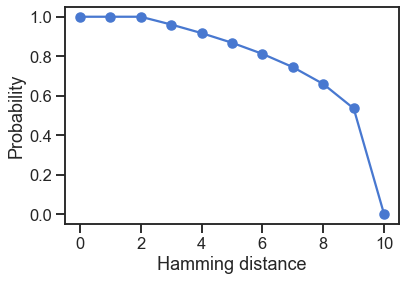

In [5]:
# tRNA modifications are shared between similar
# sequences based on a Bernoulli trial with probability
# based on the hamming distance.
# Plot the distance to probability conversion:
sim_obj.hamming2prob(plot=True)

It is important to realize that the randomly generated reference set is very influential in determining the characteristics of the resulting reads.
This is due to the random choice of modifications and their propagation into other reference sequences due to sharing.
We can see this influence clearly by plotting the coverage and observe the difference in readthrough.

In [6]:
# Function to calculate the coverage:
def seq2cov(reads, ref_len=76):
    cov = np.zeros(ref_len)
    for rds in reads:
        if rds[-2:] == 'CC':
            cov[-(len(rds)+1):] += 1
        else:
            cov[-len(rds):] += 1
    return(cov)

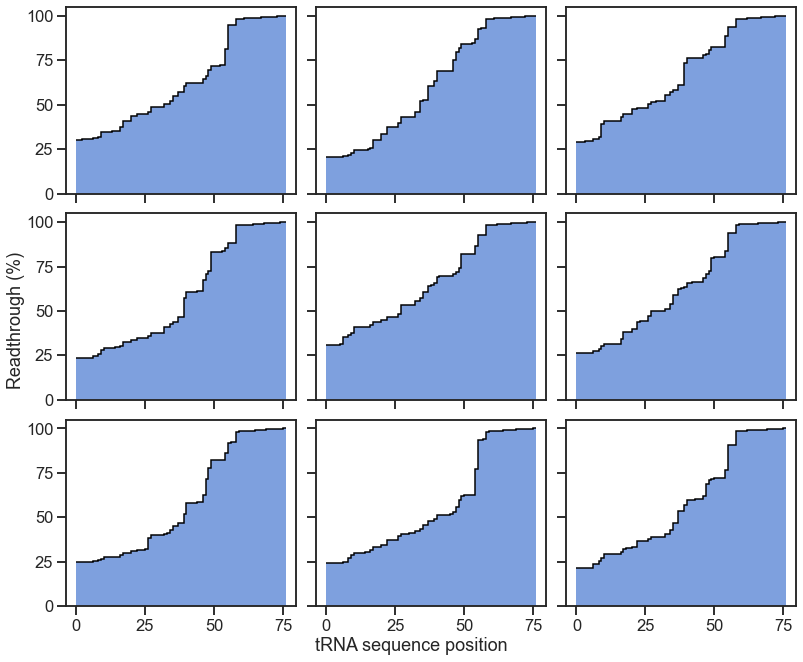

In [7]:
# Plot a 3x3 grid of coverage plots from reads
# drawn from different reference sets:
fig, ax_mat = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(11, 9))
for i in range(3):
    for j in range(3):
        # "Shuffle" the reference set (i.e. re-make it):
        sim_obj.shuffle_reference()
        # Simulate a batch of reads, without stripping internal gaps
        # because these should also contribute to the coverage:
        ann, reads = sim_obj.sim_reads(btch_size=1e4, strip_gaps=False)
        # Calculate and plot coverage:
        cov = seq2cov(reads)
        ax_mat[i, j].stairs(100*cov/len(reads), baseline=np.zeros_like(cov), fill=True, \
                            alpha=0.7)
        ax_mat[i, j].stairs(100*cov/len(reads), baseline=None, fill=False, \
                            edgecolor='black', alpha=1, linewidth=1.5)

fig.text(0.5, -0.01, 'tRNA sequence position', ha='center', size=18)
fig.text(-0.01, 0.5, 'Readthrough (%)', va='center', rotation='vertical', size=18)
fig.tight_layout()

To control for this difference in reference sets, we can use the `adjust_ref_rdthr` method which will attempt to find a randomly generated reference set that fulfills the requested restrictions.

In [8]:
# Try to find a reference set with readthrough between 40 and 33 %:
sim_obj.adjust_ref_rdthr(rdthr_max=40, rdthr_min=33)

Stopped with reference having 34.56/33.46 max/min coverage accross 5 read batches.


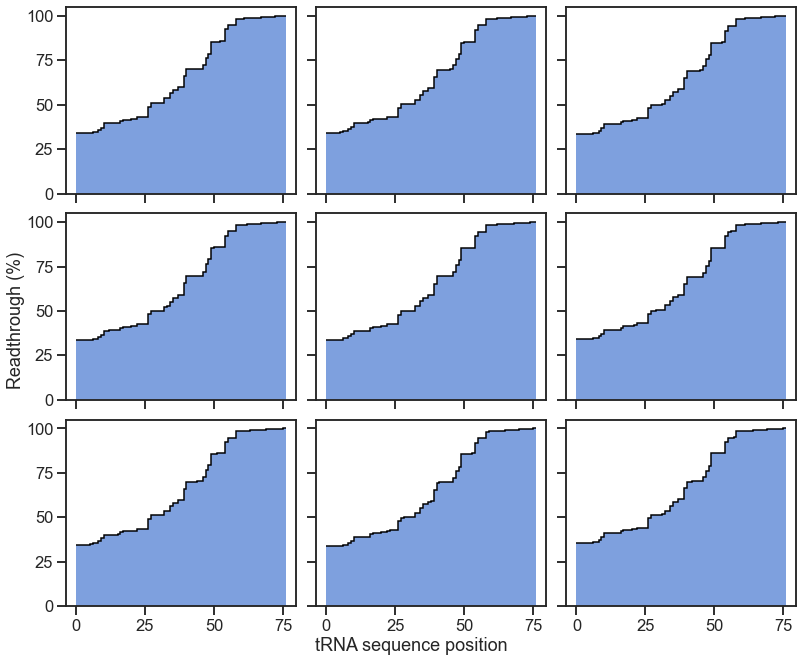

In [9]:
# Plot a 3x3 grid of coverage plots from reads
# drawn from the ~same~ reference set:
fig, ax_mat = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(11, 9))
for i in range(3):
    for j in range(3):
        # Simulate a batch of reads, without stripping internal gaps
        # because these should also contribute to the coverage:
        ann, reads = sim_obj.sim_reads(btch_size=1e4, strip_gaps=False)
        # Calculate and plot coverage:
        cov = seq2cov(reads)
        ax_mat[i, j].stairs(100*cov/len(reads), baseline=np.zeros_like(cov), fill=True, \
                            alpha=0.7)
        ax_mat[i, j].stairs(100*cov/len(reads), baseline=None, fill=False, \
                            edgecolor='black', alpha=1, linewidth=1.5)

fig.text(0.5, -0.01, 'tRNA sequence position', ha='center', size=18)
fig.text(-0.01, 0.5, 'Readthrough (%)', va='center', rotation='vertical', size=18)
fig.tight_layout()

With an adjusted reference set we can go ahead a simulate a simulate multiple batches of reads (i.e. samples), specifying the simulation parameters in a sample sheet.
Furthermore, this method will format the reads as fastq format and organize the samples similarly to UMI trimmed reads.

In [10]:
dir_dict, sample_df, tRNA_db_sim = sim_obj.sim_from_sheet(sim_sheet_fnam, NBdir, overwrite_dir=True)

In [11]:
sample_df

,sample_name_unique,sample_name,replicate,barcode_seq,barcode,species,plot_group,hue_name,hue_value,hue_order,N_UMI_observed,N_UMI_expected,percent_UMI_obs-vs-exp
0,100p_1,100p,1,GGCTGCCATGCTGTCACG,l2Sp,human,Charge-titration,Percent charge,100p,1,9900,9905.245375,99.947044
1,100p_2,100p,2,GGCTGCCATGCAAGCTG,l4Sp,human,Charge-titration,Percent charge,100p,1,9900,9905.245375,99.947044
2,75p_1,75p,1,GGCTGCCATGCTACAG,l6Sp,human,Charge-titration,Percent charge,75p,2,9908,9905.245375,100.027810
3,50p_1,50p,1,GGCTGCCATGCAACGTACA,l9Sp,human,Charge-titration,Percent charge,50p,3,9908,9905.245375,100.027810
4,50p_2,50p,2,GGCTGCCATGCTGCGA,l3Sp,human,Charge-titration,Percent charge,50p,3,9903,9905.245375,99.977331
5,25p_1,25p,1,GGCTGCCATGCAACGCATC,l5Sp,human,Charge-titration,Percent charge,25p,4,9903,9905.245375,99.977331
6,0p_1,0p,1,GGCTGCCATGCGACTA,l1Sp,human,Charge-titration,Percent charge,0p,5,9893,9905.245375,99.876375
7,0p_2,0p,2,GGCTGCCATGCACATGA,l7Sp,human,Charge-titration,Percent charge,0p,5,9893,9905.245375,99.876375


In [47]:
import pandas as pd
import bz2, copy
import logomaker as lm
import numpy as np
from numpy.random import Generator, PCG64, SFC64, Philox
rng_pg = Generator(PCG64())
rng_sf = Generator(SFC64())
rng_ph = Generator(Philox())


from Bio.SeqIO.QualityIO import FastqGeneralIterator
from Bio import Seq, SeqIO, SearchIO, SeqRecord
from mpire import WorkerPool


In [778]:
### Plotting imports ###
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.patches import StepPatch
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")
%matplotlib inline

In [779]:
try:
    import jellyfish
    def hm_dist(s1, s2):
        return(jellyfish.hamming_distance(s1, s2))
except:
    def hm_dist(s1, s2):
        return(sum(c1!=c2 for c1, c2 in zip(s1, s2)))

Define a set of 20 modifications with a penetrance i.e. probability of being in the transcript and an underlying probability of an RT event (conditioned on being found in the transcript) from either nothing, mutation (choice between random ATGC, random purine/pyrimidine, random single nt.), gap or RTstop
Use integer event codes. Reserve first 7 (1-7) for mutations, then 8 and 9 for gap/RTstop
Define these probabilities on real observations e.g. inosine, thiolations etc.


RT events:  
'0'. Silent  
'1'. Mismatch, random choice between ATGC  
'2'. Mismatch, random choice between AG (purines)  
'3'. Mismatch, random choice between TC (pyrimidines)  
'4'. Mismatch, random non-matching single nucleotide  
'5'. Reserved for mismatch  
'6'. Reserved for mismatch  
'7'. Reserved for mismatch  
'8'. Gap  
'9'. RT stop  

In [780]:
### Reference set building parameters ###
# Modifications per tRNA:
min_mods = 5  # minimum
max_mods = 16 # maximum
# Drawn from following distribution:
dstr_mods = {'norm': {'mean': 10, 'std': 3}}
# dstr_mods = {'uniform'}

# Modification donation:
accp_max_dist = 10 # hamming distance when no shared modification
accp_min_dist = 2  # hamming distance when all shared modification
# Conversion from hamming distance to probability of sharing:
accp_dist_fun = {'power': {'k': 0.3}}
# accp_dist_fun {'linear'}

In [781]:
# Extract all cyto sequences with 76 nt. length:
tRNA_ref_fnam = '../../tRNA_database/human/hg38-tRNAs.fa'
ref_dict = dict()
for record in SeqIO.parse(tRNA_ref_fnam, "fasta"):
    seq = str(record.seq)
    name = str(record.id)
    if len(seq) == 76 and 'mito' not in name and 'Escherichia_coli' not in name:
        ref_dict[name] = seq

In [782]:
# Defining a list of possibly modified positions
# based on where real modifications typically occurs
# +1 index
mod_sites = [6, 8, 9, 10, 16, 17, 20, 22, 26, 27, 32, 34, 35, 37, 39, 40, 46, 47, 48, 49, 54, 55, 58]
mod_sites = np.array(mod_sites)
mod_sites -= 1

In [783]:
# Define a list of 20 modifications with a probabilities
# of penetrance and RT events:
with open('mod_types.json', 'r') as fh:
    mod_types = eval(fh.read())

# Make sure the RT event probabilities sum to 1:
for mod_id in mod_types.keys():
    event_prob = np.zeros(10)
    for eid, prob in mod_types[mod_id]['RT event'].items():
        event_prob[eid] = prob
    event_prob = event_prob / event_prob.sum()
    mod_types[mod_id]['event_ids'] = np.arange(0, 10)
    mod_types[mod_id]['event_prob'] = event_prob

In [784]:
def draw_mod_sites(pos_arr, Nmin, Nmax, dist_param):
    if 'norm' in dist_param:
        Nmods = int(round(rng_pg.normal(dist_param['norm']['mean'], dist_param['norm']['std'])))
        if Nmods > Nmax:
            Nmods = Nmax
        elif Nmods < Nmin:
            Nmods = Nmin
    elif 'uniform':
        Nmods = int(round(rng_pg.uniform(Nmin, Nmax)))
    return(np.sort(rng_pg.choice(pos_arr, Nmods, replace=False)))

In [785]:
def hamming2prob(hdist, max_dist, min_dist, dist_fun, plot=False):
    if 'linear' in dist_fun:
        k = 1
    else:
        k = dist_fun['power']['k']
    h2p = lambda x: (1- (x - min_dist)/(max_dist-min_dist))**k
    if plot:
        hplot = np.arange(0, max_dist+1)
        p = np.ones(max_dist+1)
        p[(min_dist+1):] = h2p(hplot[(min_dist+1):])
        plt.scatter(hplot, p)
        plt.plot(hplot, p)
        plt.xlabel('Hamming distance')
        plt.ylabel('Probability')
    
    if type(hdist) is int or type(hdist) is float:
        hdist = np.array([hdist])
    
    hdist_min = hdist < min_dist
    hdist_max = hdist > max_dist
    hdist[hdist_max] = max_dist
    p_arr = h2p(hdist)
    p_arr[hdist_min] = 1.0
    return(p_arr)

array([0.])

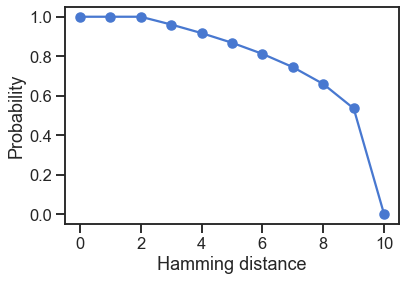

In [786]:
hamming2prob(10, accp_max_dist, accp_min_dist, accp_dist_fun, plot=True)

In [787]:
# Apply modifications to reference sequences
# using an iterative approach:
unmod_pile = copy.deepcopy(ref_dict)
mod_pile = dict()
mod_types_arr = np.array(list(mod_types.keys()))
while len(mod_pile) < len(ref_dict):
    for name in list(unmod_pile.keys()):
        if name in mod_pile:
            continue
        seq = unmod_pile[name]
        del unmod_pile[name]
        mod_pos = draw_mod_sites(mod_sites, min_mods, max_mods, dstr_mods)
        mod_draw = rng_pg.choice(mod_types_arr, len(mod_pos), replace=True)
        # Make modification array:
        mod_arr = np.zeros(len(seq), dtype=int)
        mod_arr[mod_pos] = mod_draw
        # Make penetrance probability array:
        pen_prob_arr = np.zeros(len(seq), dtype=float)
        pen_prob_arr[mod_pos] = np.array([mod_types[m]['penetrance'] for m in mod_draw])
        # Move to pile of modified sequences:
        mod_pile[name] = {'seq': np.array(list(seq)), 'mods': mod_arr, 'pen_prob': pen_prob_arr}
        
        # Find modification acceptors:
        name_arr = np.array(list(unmod_pile.keys()))
        hdist_arr = np.array([hm_dist(seq, unmod_pile[an]) for an in name_arr])
        prob_arr = hamming2prob(hdist_arr, accp_max_dist, accp_min_dist, accp_dist_fun)
        name_draw = rng_pg.binomial(1, prob_arr) > 0
        # Move those selected to pile of modified sequences:
        for acc_name in name_arr[name_draw]:
            acc_seq = unmod_pile[acc_name]
            del unmod_pile[acc_name]
            # Mask positions where donor nt. != acceptor nt.
            dnr_mask = np.array([dnt != ant for dnt, ant in zip(seq, acc_seq)])
            mod_arr_accp = copy.deepcopy(mod_arr)
            mod_arr_accp[dnr_mask] = 0
            mod_pile[acc_name] = {'seq': np.array(list(acc_seq)), 'mods': mod_arr_accp, 'pen_prob': pen_prob_arr}

assert(len(unmod_pile) == 0)

In [812]:
### Sequence simulation parameters ###
# Batch size i.e. number of reads to simulate:
btch_size = 1e4

# Baseline mismatch, gap and RTstop:
bsln_mis = 0.001
bsln_gap = 0.0001
bsln_stop = 0

# Modification penetrance and readthrough scaling:
# scaling from 0 to 1:
mod_pen_scl = 1
mod_rdthr_scl = 0.7
# Gap multiplier drawn from poisson distribution
# with lambda=gap_nghbr_lbd:
gap_nghbr_lbd = 0.4
gap_nghbr_max = 5 # max gaps

# Aminoacylation charge:
AA_charge = 50

In [813]:
# Now simulate reads using sequence simulation parameters
# and the two input dictionaries:
# mod_pile => containing arrays of 'seq' (ATGC) and 'mods' (0 if none, 1-20 mod codes)
# mod_types => for each mod code contains penetrance and even probabilities

btch_size = int(btch_size)
ref_names = list(mod_pile.keys())
ref_idx_arr = np.arange(0, len(ref_names))
seq_len = len(mod_pile[ref_names[0]]['seq'])
mat_dim = (btch_size, seq_len)
seq_dtype = mod_pile[ref_names[0]]['seq'].dtype
# Storing the reads (i.e. sequences) and modifications
# in a matrix with one column per read: 
read_mat = np.empty(mat_dim, dtype=seq_dtype)
read_anno = list()
mod_mat = np.zeros(mat_dim, dtype=int)
# Penetrance matrix:
pen_prob_mat = np.zeros(mat_dim, dtype=float)

# Sample reference sequences, insert them into batch matrix:
ref_idx_draw = rng_pg.choice(ref_idx_arr, btch_size, replace=True)
for ci, ri in enumerate(ref_idx_draw):
    read_anno.append(ref_names[ri])
    read_mat[ci, :] = mod_pile[ref_names[ri]]['seq']
    mod_mat[ci, :] = mod_pile[ref_names[ri]]['mods']
    # Scale the penetrance to user input:
    pen_prob_mat[ci, :] = mod_pile[ref_names[ri]]['pen_prob'] * mod_pen_scl


# Draw baseline RT events:
event_arr = np.array([0, 1, 8, 9]) # 0=no event, 1=random nt., 8=gap, 9=stop
prob_arr = np.array([0, bsln_mis, bsln_gap, bsln_stop])
prob_arr[0] = 1 - sum(prob_arr)
bsln_evnt_mat = rng_pg.choice(event_arr, p=prob_arr, size=mat_dim, replace=True)

# Sample modified positions based on penetrance:
mod_mask = rng_pg.binomial(1, pen_prob_mat) > 0

# Silence non-penetrating modifications:
mod_mat[~mod_mask] = 0
# Silence baseline events coinciding with a modification:
bsln_evnt_mat[mod_mask] = 0

# Draw RT events on modified positions:
event_ids = np.arange(0, 10)
mod_evnt_mat = np.zeros(mat_dim, dtype=int)
for mt in mod_types.keys():
    md_mask = (mod_mat == mt)
    # Scale the readthrough:
    evnt_prob = copy.deepcopy(mod_types[mt]['event_prob'])
    evnt_prob[9] *= (1 - mod_rdthr_scl)
    evnt_prob /= evnt_prob.sum()
    mod_evnt_mat[md_mask] = rng_pg.choice(event_ids, p=evnt_prob, size=md_mask.sum())

# Collect all RT events:
evnt_mat = bsln_evnt_mat + mod_evnt_mat

# Sample RT events and insert into each read: 
rnd_nt = np.array(list('ATGC'))
pur_nt = np.array(list('AG'))
pyr_nt = np.array(list('TC'))
non_nbs = {
    'A': np.array(list('TGC')),
    'T': np.array(list('AGC')),
    'G': np.array(list('ATC')),
    'C': np.array(list('ATG'))
}
for rte in event_ids:
    if rte == 0:    # silent
        continue
    elif rte in [5, 6, 7]: # reserved but not used
        continue
    ri, ci = np.where(evnt_mat == rte)
    if rte == 1:    # random nt.
        read_mat[ri, ci] = rng_pg.choice(rnd_nt, size=len(ri))
    elif rte == 2:  # random purine
        read_mat[ri, ci] = rng_pg.choice(pur_nt, size=len(ri))
    elif rte == 3:  # random pyrimidine
        read_mat[ri, ci] = rng_pg.choice(pyr_nt, size=len(ri))
    elif rte == 4:  # non-matching nt.
        for nbs in list('ATGC'):
            nbs_mask = (read_mat[ri, ci] == nbs)
            read_mat[ri[nbs_mask], ci[nbs_mask]] = rng_pg.choice(non_nbs[nbs], size=sum(nbs_mask))

    elif rte == 8:  # non-matching nt.
        # Sample number of gaps to expand with:
        gap_nghbr = rng_pg.poisson(gap_nghbr_lbd, size=len(ri))
        gap_nghbr[gap_nghbr > gap_nghbr_max] = gap_nghbr_max
        # Expand the gap positions from 3p towards the 5p:
        ri_exp = np.zeros(sum(gap_nghbr) + len(ri), dtype=int)
        ci_exp = np.zeros(sum(gap_nghbr) + len(ri), dtype=int)
        exp_i = 0
        for rii, cii, Ngap in zip(ri, ci, gap_nghbr):
            for gp in range(Ngap+1):
                ri_exp[exp_i] = rii
                ci_exp[exp_i] = cii - gp
                exp_i += 1
        ci_exp[ci_exp < 0] = 0 # gaps cannot go beyond the 5p (obviously)
        read_mat[ri_exp, ci_exp] = '-'

    elif rte == 9:  # stop
        # Find the maximum column index
        # for each stop i.e. the stop
        # closest to the 3p:
        max_ci_dict = dict()
        for rii, cii in zip(ri, ci):
            try:
                max_ci_dict[rii] = max(max_ci_dict[rii], cii)
            except:
                 max_ci_dict[rii] = cii

        # Enforce the stop by removing bases in the read:
        for rii, cii in max_ci_dict.items():
            read_mat[rii, :(cii+1)] = ''

# Trim 3p base off all uncharged tRNA reads:
unch_prob = (100 - AA_charge) / 100
unch_mask = rng_pg.binomial(1, unch_prob, size=mat_dim[0]) > 0
read_mat[unch_mask, -1] = ''

In [908]:
class TRNA_ReadSim:
    '''
    Simulate tRNA-Seq reads.
    Initialize by building a tRNA reference set,
    complete with modified positions and shared
    modifications based on sequence similarity.
    Using this reference set reads can be sampled
    by specifying sampling parameters or a sample
    sheet enabling multiple samples to be generated.

    Keyword arguments:
    min_mods -- Minimum modified positions per tRNA (default 5)
    max_mods -- Maximum modified positions per tRNA (default 16)
    dstr_mods -- Distribution to drawn the number of modifications from (default {'norm': {'mean': 10, 'std': 3}})
    accp_max_dist -- Maximum hamming distance for sharing modifications i.e. no sharing at this distance (default 10)
    accp_min_dist -- Minimum hamming distance for sharing modifications i.e. certain sharing at this distance (default 2)
    accp_dist_fun -- Function for conversion from hamming distance to probability of sharing modifications (default {'power': {'k': 0.3}})
    ref_len -- Length reference sequences to isolate (default 76)
    ref_excl -- String in name to exclude from reference fx if spike-in control (default 'Escherichia_coli')
    mod_sites -- Positions in the tRNA to modify. If None, using pre-speficied list of 23 positions (default None)
    '''
    def __init__(self, tRNA_ref_fnam, mod_types_fnam, \
                 min_mods=5, max_mods=16, \
                 dstr_mods={'norm': {'mean': 10, 'std': 3}}, \
                 accp_max_dist=10, accp_min_dist=2, \
                 accp_dist_fun={'power': {'k': 0.3}}, \
                 ref_len=76, ref_excl='Escherichia_coli', \
                 mod_sites=None):
        self.tRNA_ref_fnam = tRNA_ref_fnam
        self.ref_len = ref_len
        self.ref_excl = ref_excl
        self.min_mods = min_mods
        self.max_mods = max_mods
        self.dstr_mods = dstr_mods
        self.accp_max_dist = accp_max_dist
        self.accp_min_dist = accp_min_dist
        self.accp_dist_fun = accp_dist_fun
        # Defining a list of possibly modified positions
        # based on where real modifications typically occurs
        # +1 index
        if mod_sites is None:
            self.mod_sites = [6, 8, 9, 10, 16, 17, \
                              20, 22, 26, 27, 32, 34, \
                              35, 37, 39, 40, 46, 47, \
                              48, 49, 54, 55, 58]
        else:
            self.mod_sites = mod_sites
        self.mod_sites = np.array(self.mod_sites)
        self.mod_sites -= 1

        # Define a list of 20 modifications with a probabilities
        # of penetrance and RT events:
        with open(mod_types_fnam, 'r') as fh:
            self.mod_types = eval(fh.read())
        # Make sure the RT event probabilities sum to 1:
        for mod_id in self.mod_types.keys():
            event_prob = np.zeros(10)
            for eid, prob in self.mod_types[mod_id]['RT event'].items():
                event_prob[eid] = prob
            event_prob = event_prob / event_prob.sum()
            self.mod_types[mod_id]['event_ids'] = np.arange(0, 10)
            self.mod_types[mod_id]['event_prob'] = event_prob


        # Sample the reference set:
        self.ref_dct = self._gen_ref()
            
    def _gen_ref(self):
        # Extract all cyto sequences with ref_len nt. length:
        ref_dict = dict()
        for record in SeqIO.parse(self.tRNA_ref_fnam, "fasta"):
            seq = str(record.seq)
            name = str(record.id)
            if len(seq) == self.ref_len and 'mito' not in name and self.ref_excl not in name:
                ref_dict[name] = seq

        # Apply modifications to reference sequences
        # using an iterative approach:
        unmod_pile = copy.deepcopy(ref_dict)
        mod_pile = dict()
        mod_types_arr = np.array(list(self.mod_types.keys()))
        while len(mod_pile) < len(ref_dict):
            for name in list(unmod_pile.keys()):
                if name in mod_pile:
                    continue
                seq = unmod_pile[name]
                del unmod_pile[name]
                mod_pos = self._draw_mod_sites(self.mod_sites, self.min_mods, self.max_mods, self.dstr_mods)
                mod_draw = rng_pg.choice(mod_types_arr, len(mod_pos), replace=True)
                # Make modification array:
                mod_arr = np.zeros(len(seq), dtype=int)
                mod_arr[mod_pos] = mod_draw
                # Make penetrance probability array:
                pen_prob_arr = np.zeros(len(seq), dtype=float)
                pen_prob_arr[mod_pos] = np.array([self.mod_types[m]['penetrance'] for m in mod_draw])
                # Move to pile of modified sequences:
                mod_pile[name] = {'seq': np.array(list(seq)), 'mods': mod_arr, 'pen_prob': pen_prob_arr}

                # Find modification acceptors:
                name_arr = np.array(list(unmod_pile.keys()))
                hdist_arr = np.array([hm_dist(seq, unmod_pile[an]) for an in name_arr])
                prob_arr = self.hamming2prob(hdist_arr, self.accp_max_dist, self.accp_min_dist, self.accp_dist_fun)
                name_draw = rng_pg.binomial(1, prob_arr) > 0
                # Move those selected to pile of modified sequences:
                for acc_name in name_arr[name_draw]:
                    acc_seq = unmod_pile[acc_name]
                    del unmod_pile[acc_name]
                    # Mask positions where donor nt. != acceptor nt.
                    dnr_mask = np.array([dnt != ant for dnt, ant in zip(seq, acc_seq)])
                    mod_arr_accp = copy.deepcopy(mod_arr)
                    mod_arr_accp[dnr_mask] = 0
                    mod_pile[acc_name] = {'seq': np.array(list(acc_seq)), 'mods': mod_arr_accp, 'pen_prob': pen_prob_arr}

        assert(len(unmod_pile) == 0)
        return(mod_pile)

    def _draw_mod_sites(self, pos_arr, Nmin, Nmax, dist_param):
        if 'norm' in dist_param:
            Nmods = int(round(rng_pg.normal(dist_param['norm']['mean'], dist_param['norm']['std'])))
            if Nmods > Nmax:
                Nmods = Nmax
            elif Nmods < Nmin:
                Nmods = Nmin
        elif 'uniform':
            Nmods = int(round(rng_pg.uniform(Nmin, Nmax)))
        return(np.sort(rng_pg.choice(pos_arr, Nmods, replace=False)))

    def hamming2prob(self, hdist, max_dist, min_dist, dist_fun, plot=False):
        '''
        Convert hamming distance to probability of
        sharing modifications.
        
        Keyword arguments:
        plot -- Only return plot of the resulting distance to probability conversion (default False)
        '''
        if 'linear' in dist_fun:
            k = 1
        else:
            k = dist_fun['power']['k']
        h2p = lambda x: (1- (x - min_dist)/(max_dist-min_dist))**k
        if plot:
            hplot = np.arange(0, max_dist+1)
            p = np.ones(max_dist+1)
            p[(min_dist+1):] = h2p(hplot[(min_dist+1):])
            plt.scatter(hplot, p)
            plt.plot(hplot, p)
            plt.xlabel('Hamming distance')
            plt.ylabel('Probability')
            return()

        if type(hdist) is int or type(hdist) is float:
            hdist = np.array([hdist])

        hdist_min = hdist < min_dist
        hdist_max = hdist > max_dist
        hdist[hdist_max] = max_dist
        p_arr = h2p(hdist)
        p_arr[hdist_min] = 1.0
        return(p_arr)

    def shuffle_reference(self):
        ''' Re-sample reference database.'''
        self.ref_dct = self._gen_ref()

    def sim_reads(self, btch_size=1e6, bsln_mis=1e-3, \
                     bsln_gap=1e-4, bsln_stop=1e-3, mod_pen_scl=1, \
                     mod_rdthr_scl=0.1, gap_add_lbd=0.4, gap_max=4, \
                     AA_charge=50, strip_gaps=True):
        '''
        Sample tRNA-Seq reads.
        
        Keyword arguments:
        btch_size -- Number of reads to simulate (default 1e6)
        bsln_mis -- Baseline (i.e. not modification induced) mismatch rate (default 1e-3)
        bsln_gap -- Baseline (i.e. not modification induced) gap rate (default 1e-4)
        bsln_stop -- Baseline (i.e. not modification induced) RT stop rate (default 1e-3)
        mod_pen_scl -- Modification penetrance scaling from 0 to 1, with 0 making all modifications non-penetrant(default 1)
        mod_rdthr_scl -- RT readthrough scaling from 0 to 1, with 1 cancelling all RT stop events (default 0.1)
        gap_add_lbd -- Poisson distribution lambda to draw additional gaps downstream a modification induced gap position (default 0.4)
        gap_max -- Max number of gaps induced by one modification (default 4)
        AA_charge -- Aminoacylation charge as defined by the CCA to CC ratio. CCA or CC-ends sampled randomly (default 50)
        strip_gaps -- Strip gap characters '-' from output reads (default True)
        '''

        # Simulate reads using sequence simulation parameters
        # and the two input dictionaries:
        # self.ref_dct => containing arrays of 'seq' (ATGC) and 'mods' (0 if none, 1-20 mod codes)
        # self.mod_types => for each mod code contains penetrance and RT event probabilities
        btch_size = int(btch_size)
        ref_names = list(self.ref_dct.keys())
        ref_idx_arr = np.arange(0, len(ref_names))
        mat_dim = (btch_size, self.ref_len)
        seq_dtype = self.ref_dct[ref_names[0]]['seq'].dtype
        # Storing the reads (i.e. sequences) and modifications
        # in a matrix with one column per read: 
        read_mat = np.empty(mat_dim, dtype=seq_dtype)
        read_anno = list()
        mod_mat = np.zeros(mat_dim, dtype=int)
        # Penetrance matrix:
        pen_prob_mat = np.zeros(mat_dim, dtype=float)

        # Sample reference sequences, insert them into batch matrix:
        ref_idx_draw = rng_pg.choice(ref_idx_arr, btch_size, replace=True)
        for ci, ri in enumerate(ref_idx_draw):
            read_anno.append(ref_names[ri])
            read_mat[ci, :] = self.ref_dct[ref_names[ri]]['seq']
            mod_mat[ci, :] = self.ref_dct[ref_names[ri]]['mods']
            # Scale the penetrance to user input:
            pen_prob_mat[ci, :] = self.ref_dct[ref_names[ri]]['pen_prob'] * mod_pen_scl


        # Draw baseline RT events:
        event_arr = np.array([0, 1, 8, 9]) # 0=no event, 1=random nt., 8=gap, 9=stop
        prob_arr = np.array([0, bsln_mis, bsln_gap, bsln_stop])
        prob_arr[0] = 1 - sum(prob_arr)
        bsln_evnt_mat = rng_pg.choice(event_arr, p=prob_arr, size=mat_dim, replace=True)

        # Sample modified positions based on penetrance:
        mod_mask = rng_pg.binomial(1, pen_prob_mat) > 0

        # Silence non-penetrating modifications:
        mod_mat[~mod_mask] = 0
        # Silence baseline events coinciding with a modification:
        bsln_evnt_mat[mod_mask] = 0

        # Draw RT events on modified positions:
        event_ids = np.arange(0, 10)
        mod_evnt_mat = np.zeros(mat_dim, dtype=int)
        for mt in self.mod_types.keys():
            md_mask = (mod_mat == mt)
            # Scale the readthrough:
            evnt_prob = copy.deepcopy(self.mod_types[mt]['event_prob'])
            evnt_prob[9] *= (1 - mod_rdthr_scl)
            evnt_prob /= evnt_prob.sum()
            mod_evnt_mat[md_mask] = rng_pg.choice(event_ids, p=evnt_prob, size=md_mask.sum())

        # Collect all RT events:
        evnt_mat = bsln_evnt_mat + mod_evnt_mat

        # Sample RT events and insert into each read: 
        rnd_nt = np.array(list('ATGC'))
        pur_nt = np.array(list('AG'))
        pyr_nt = np.array(list('TC'))
        non_nbs = {
            'A': np.array(list('TGC')),
            'T': np.array(list('AGC')),
            'G': np.array(list('ATC')),
            'C': np.array(list('ATG'))
        }
        for rte in event_ids:
            if rte == 0:    # silent
                continue
            elif rte in [5, 6, 7]: # reserved but not used
                continue
            ri, ci = np.where(evnt_mat == rte)
            if rte == 1:    # random nt.
                read_mat[ri, ci] = rng_pg.choice(rnd_nt, size=len(ri))
            elif rte == 2:  # random purine
                read_mat[ri, ci] = rng_pg.choice(pur_nt, size=len(ri))
            elif rte == 3:  # random pyrimidine
                read_mat[ri, ci] = rng_pg.choice(pyr_nt, size=len(ri))
            elif rte == 4:  # non-matching nt.
                for nbs in list('ATGC'):
                    nbs_mask = (read_mat[ri, ci] == nbs)
                    read_mat[ri[nbs_mask], ci[nbs_mask]] = rng_pg.choice(non_nbs[nbs], size=sum(nbs_mask))

            elif rte == 8:  # non-matching nt.
                # Sample number of gaps to expand with:
                gap_nghbr = rng_pg.poisson(gap_add_lbd, size=len(ri))
                gap_nghbr[gap_nghbr > gap_max] = gap_max
                # Expand the gap positions from 3p towards the 5p:
                ri_exp = np.zeros(sum(gap_nghbr) + len(ri), dtype=int)
                ci_exp = np.zeros(sum(gap_nghbr) + len(ri), dtype=int)
                exp_i = 0
                for rii, cii, Ngap in zip(ri, ci, gap_nghbr):
                    for gp in range(Ngap+1):
                        ri_exp[exp_i] = rii
                        ci_exp[exp_i] = cii - gp
                        exp_i += 1
                ci_exp[ci_exp < 0] = 0 # gaps cannot go beyond the 5p (obviously)
                read_mat[ri_exp, ci_exp] = '-'

            elif rte == 9:  # stop
                # Find the maximum column index
                # for each stop i.e. the stop
                # closest to the 3p:
                max_ci_dict = dict()
                for rii, cii in zip(ri, ci):
                    try:
                        max_ci_dict[rii] = max(max_ci_dict[rii], cii)
                    except:
                         max_ci_dict[rii] = cii

                # Enforce the stop by removing bases in the read:
                for rii, cii in max_ci_dict.items():
                    read_mat[rii, :(cii+1)] = ''

        # Trim 3p base off all uncharged tRNA reads:
        unch_prob = (100 - AA_charge) / 100
        unch_mask = rng_pg.binomial(1, unch_prob, size=mat_dim[0]) > 0
        read_mat[unch_mask, -1] = ''
        
        # Return simulated reads with their reference annotations:
        if strip_gaps:
            sim_reads = [''.join(read_mat[si]).strip('-') for si in range(mat_dim[0])]
        else:
            # Still strip 5p gaps but preserve internal gaps:
            sim_reads = [''.join(read_mat[si]).lstrip('-') for si in range(mat_dim[0])]
        return(read_anno, sim_reads)

In [909]:
sim_obj = TRNA_ReadSim(tRNA_ref_fnam, 'mod_types.json')

In [910]:
ann, sim_reads = sim_obj.sim_reads(btch_size=1e5, strip_gaps=False)

In [911]:
ann, sim_reads = sim_obj.sim_reads(btch_size=1e5, strip_gaps=False)


cov = np.zeros(76)
for rds in sim_reads:
    if rds[-2:] == 'CC':
        cov[-(len(rds)+1):] += 1
    else:
        cov[-len(rds):] += 1
        

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.bar(np.arange(1, 77), 100*cov/len(sim_reads), width=1)

<BarContainer object of 76 artists>

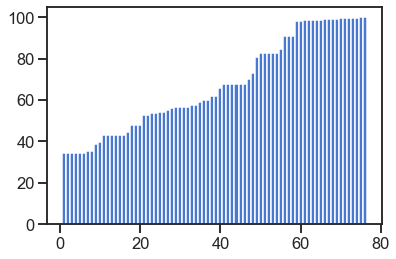

In [912]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.bar(np.arange(1, 77), 100*cov/len(sim_reads), width=1)

In [913]:
sim_reads

['GTCCTAATGGATAGGGCATTGGCATACTAATCCAGGGATTGTGGGTTCGAGTCCCATCTGGGGTGCCA',
 'GTTTCCGTAGTGTAGTAGTTATCACGTTCGCCTCACACGCGAAAGGACCCCGGTTCGAAACTGGGCGGAAACACC',
 'GGTAGAGCAGAGGACTATAGGTCCTTAGCTTGCTGGTTCGATTCCAGCTTGAAGGACC',
 'GCCCTATTCGCGCAGCGGGC--CGCGCCAGTCTCATGATCTGAAGTTGATGAGTGCGAGCCTCAGAGAGGGCACCA',
 'GATAAGGCGTCTGACTTCGGATCAGAAGATTGAGGGTTCGAATCCCTTCGTGGTTGCC',
 'GGTTCCATTGTGTAGCGGTTATCACGTCTGCTTTACACGGAGAAGGTCCTGGGTT---GCCCCAGTGGAACCACC',
 'CCCCGGTTCAAATCCGGGTGCCCCCTCC',
 'GCCCAGCTACCTCAGGCGGTAGAGCACAAGACTCTTAATGTCAGGGTCGTGGGTTTGGGCCCTGTGTTGAGCACC',
 'GGGGGATAAGCTCAAGCGGAAGAGCGCCTGCTTAGCGTGCAAGAGGTAACAGGATCGATGCCTGCATTCTCCACCA',
 'AGAGCT-CAGACTTTTAA-CTGAGGGTCCGGGGGTCATGTCCCTGTTCGGGCGCC',
 'GTCTAGCTACATCAGTTGGTAGAGCATAAGACTCTTAATATCAGGGACGTGGGTTTGAGCCCTACGTTGGGCGCCA',
 'GGATAAGGCGTCTGACTTCGGACCAGAAGATTGAGGGTTCGAATCCCTCCGTGGTTACC',
 'GTTTCCGTAGTGTAGTAGTTATTATGATCGCCTCACACGCGAAAAGGCCCCGGTTCG-AATCAGGCGGGAACACCA',
 'CAAGCCTCAGAGAGGGCACCA',
 'GTTTCCGTAGTGTAGTAGTTATCACGTTCGCCTAACACGCGAAAGGACCCTG

In [840]:
arr = np.zeros(10)

In [849]:
arr

array([2., 2., 2., 2., 2., 3., 3., 3., 3., 3.])

In [848]:
arr[-10:] += 1
arr[-5:] += 1

In [ ]:
unch_prob = (100 - AA_charge) / 100
unch_mask = rng_pg.binomial(1, unch_prob, size=mat_dim[0]) > 0

In [814]:
sim_reads = [''.join(read_mat[si]).lstrip('-') for si in range(mat_dim[0])]

In [809]:
ann_rd = dict()
for sr, ra in zip(sim_reads, read_anno):
    try:
        ann_rd[ra].append(sr)
    except:
        ann_rd[ra] = list()
        ann_rd[ra].append(sr)

In [803]:
'-QWER'.lstrip('-')

'QWER'

In [815]:
sim_reads[0:20]

['GTTTCCGAAGTGTAGTGGTTATCACGTTCGCCTAGCACGCGAAAGGTTCCCGGTTCGAAACCGGGCGGAAACACC',
 'GGGGGTATTGCTCAGGTGGTAGAGCATTTCACTTCAGATCAAGAG-TCCCCGGTCCAAATCCGGGTGCCCCCTCCA',
 'TCCCTGGTGGTCTAGTGGCTA-GATTCGGCGCT-TCACCGCCTGCA-CTCGAGTCCGATTCCTGGTCAGGGAACC',
 'AGGGCATCAGCCTGCAGATCTAAAGCGGTCTGGTTCAATTCTGGGTTTTGGCACC',
 'TGAAGTACTGCAGCTGTCTGGTTCATTTCCGGGTTTCGACACC',
 'AGCGTTAGACTGAAGATCTAAAGGTCCCTGGTTCGATCCCGGGTTTCGGCACCA',
 'GGGGGTATAGCTCAGGTGGTAGAGCATTTGACTTCAGATCAAGAGGTCCCCGGTCCAAATCCGGGTGCCCCCTCCA',
 'TGGACT-CTAATTCAAAGGTTGTGGGTTCGAATCCCACCAGAGTCGCC',
 'CGCCTGCACTCTCCACC',
 'GCCTAATGGAAATGGCACTGGCCTCATAAGCCAGGGCTTGTGGGTTCGAGTCCCACCTGGGGTGCCA',
 'TGGGATCAATGACCACATTCTCCACC',
 'GTTTCCGAAGTGTAGTGGTTATCACGTTTGCCTAACACGCGAAAGGTTCCCGGTTCGAAACCGGGCAGAAACACCA',
 'TTGAGGGCCCAGGTCTCAAGTCCCTGTTTGGGTGCC',
 'TCCGTGGTTGTCTAGTGGCTAGGATTCGGCGCTCTCACCACCTGCAGCCCGAGTCCGGTTCCTGGTCAGGGAACCA',
 'CTCAGCTGGGAAAGCATTAGACTGAAGATGTAAAGGTCTCTGGTTTGATCCTGGGTTTCAGAACC',
 'TGGGATCGATGCCCACATTCTCCACC',
 'GCCTCGTTAGCGCAGTAGGCAGCGCGT

In [806]:
x_obs = np.array([len(sr) for sr in sim_reads])

(array([1123., 1456.,  703.,  408.,  695.,  636.,  315.,  129.,  895.,
        3640.]),
 array([16., 22., 28., 34., 40., 46., 52., 58., 64., 70., 76.]),
 <BarContainer object of 10 artists>)

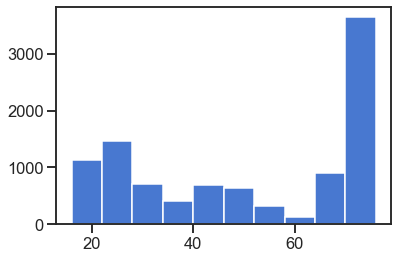

In [807]:
plt.hist(x_obs)